In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchmetrics.functional import r2_score, mean_squared_error, mean_absolute_error

# 1 Non-linear regression

In [2]:
# check if a GPU is available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

## 1.1 Data acquisition

We keep the Dataset wrapper from Ex. 02.

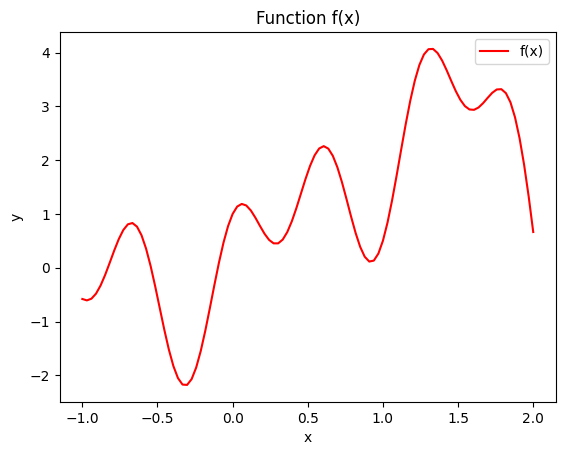

In [3]:
#Defining the non-linear fn and plot it
def f(x):
    return x + 1.5 * x**2 + 0.5 * x**3 - 0.7 * x**4 + np.sin(5*x) + np.cos(10*x)

x = np.linspace(-1,2,100).reshape(-1,1)
y = f(x)

plt.plot(x,y,label = 'f(x)', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Function f(x)')
plt.legend()
plt.show()

In Exercise 02, we manually split our data into training and test set. Since this is a standard procedure, it is helpful to write a function doing that for us. Feel free to modify it!

In [4]:
#we import Data wrapper using torch
class Data(Dataset):
  """Dataset wrapper. Takes numpy arrays and stores them as torch tensors.
    Data is transformed to the device."""
  def __init__(self, x: np.ndarray,
                y: np.ndarray,
                device: str = DEVICE):
    self.x = torch.from_numpy(x).float().to(device)
    self.y =  torch.from_numpy(y ).float().to(device)
    self.len = self.x.shape[0]
  
  def __getitem__(self, index: int) -> tuple:
    return self.x[index], self.y[index]
  
  def __len__(self) -> int:
    return self.len

In [5]:
#splitting the data into train,test data with training frac of 75%
def split_data(x_full: np.ndarray,
               y_full: np.ndarray,
               train_fraction: float):
    """Generates three pytorch Datasets (full, train, test) given a set of features and labels."""

    # define fraction of data used for training
    assert x_full.shape[0] == y_full.shape[0] #checks if x,y paired correctly
    
    n_samples = y_full.shape[0]

    n_train = int(train_fraction * n_samples) #no.of samples to be used to train

    # get indices for training and test set
    ids = np.arange(n_samples) #creates an array of samples 0 to (n_samples-1)
    np.random.shuffle(ids) #randomise the ids
    ids_train, ids_test  = np.split(ids, [n_train]) #get test n train indices

    #finally load the data into a datawrapper
    #selects the [ids_train] indices within x,y datasets
    all_data = Data(x_full, y_full)
    train_data = Data(x_full[ids_train], y_full[ids_train])
    test_data = Data(x_full[ids_test], y_full[ids_test])

    return all_data, train_data, test_data

# split data with 75% training
all_data, train_data, test_data = split_data(x, y, train_fraction=0.75)


Text(0.5, 1.0, 'Function f(x) with Training and Test Data')

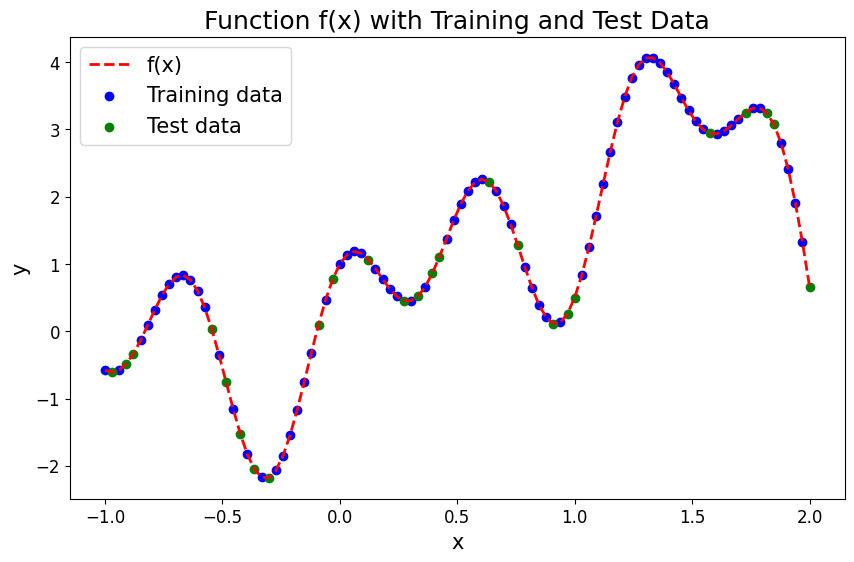

In [6]:
#plot the function and the data sets
plt.figure(figsize=(10,6)) #dim of the figure

#x,y=f(x) plot with color,linestyle and width
plt.plot(x,y,label='f(x)',color='red',linestyle='--', linewidth=2)

#extract the test,train datasets from cpu(tensors)to numpy
x_train = train_data.x.cpu().numpy()
y_train = train_data.y.cpu().numpy()
x_test = test_data.x.cpu().numpy()
y_test = test_data.y.cpu().numpy()

#train data plot
plt.scatter(x_train, y_train, label='Training data', color='blue')
#test data plot
plt.scatter(x_test, y_test, label='Test data', color='green')

#adding legends
plt.legend(fontsize=15)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Function f(x) with Training and Test Data', fontsize=18)

## 1.2 Neural network

### non-Linear eqn n splitting data into test,train

In [ ]:
# # Define the function f(x)
# def f(x):
#     return x + 1.5 * x**2 + 0.5 * x**3 - 0.7 * x**4 + np.sin(5 * x) + np.cos(10 * x)

# # Generate and split data
# x = np.linspace(-1, 2, 100).reshape(-1, 1)
# y = f(x)
# x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.75, random_state=42)

# # Normalize the data
# # scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)


## Data wrapper

In [ ]:
# #Data wrapper set
# class Data(Dataset):
#     def __init__(self, x: np.ndarray, y: np.ndarray, device: str = 'cpu'):
#         self.x = torch.from_numpy(x).float().to(device)
#         self.y = torch.from_numpy(y).float().to(device)
#         self.len = self.x.shape[0]
    
#     def __getitem__(self, index: int) -> tuple:
#         return self.x[index], self.y[index]
    
#     def __len__(self):
#         return self.len

### linear regression in nn using MLP(multi-layered perception)

In [ ]:
# #linear regression in nn using MLP(multi-layered perception)
# #(Rect. linear unit) ReLU(x) = max(0,x) is activated.
# #Here ReLU passes only positive values in (0,x)
# class MLP(nn.Module):
#     def __init__(self, n_units: list, activation= nn.ReLU()):
#         """
#             Simple multi-layer perceptron (MLP).

#             Parameters:
#             -----------
#             n_units : List of integers specifying the dimensions of input and output and the hidden layers.
#             activation: Activation function used for non-linearity. 


#             Example:
#             -----------

#             dim_hidden = 100
#             dim_in = 2
#             dim_out = 5

#             # MLP with input dimension 2, output dimension 5, and 4 hidden layers of dimension 100
#             model = MLP([dim_in,
#                         dim_hidden,
#                         dim_hidden,
#                         dim_hidden,
#                         dim_hidden,
#                         dim_out],activation=nn.ReLU()).to(DEVICE)

#         """
#         super().__init__()

#         # Get input and output dimensions
#         dims_in = n_units[:-1]
#         dims_out = n_units[1:]

#         layers = []

#         # Add linear layers (and activation function after all layers except the final one)
#         for i, (dim_in, dim_out) in enumerate(zip(dims_in, dims_out)):
#             layers.append(torch.nn.Linear(dim_in, dim_out))
            
#             if i < len(n_units) - 2:
#                 layers.append(activation)
        

#         self._layers = torch.nn.Sequential(*layers)
#         #method takes layers list and combines into a single module

#     def forward(self, x):
#         """
#             MLP forward pass

#         """
#         return self._layers(x)
    
#     def count_parameters(self): 
#         """
#             Counts the number of trainable parameters.

#         """
#         return sum(p.numel() for p in self.parameters() if p.requires_grad)

In Exercise 02, we saw how a basic training loop in pytorch looks like. Since we will need this exact training procedure a number of times, it is useful to define a function for it. Feel free to modify it!

## Training model for datasets

In [ ]:
# #training model for datasets
# def train(model:nn.Module, train_loader: DataLoader, optimizer: torch.optim.Optimizer, criterion: nn.modules.loss._Loss):
#     """
#         Basic training loop for a pytorch model.

#         Parameters:
#         -----------
#         model : pytorch model.
#         train_loader : pytorch Dataloader containing the training data.
#         optimizer: Optimizer for gradient descent. 
#         criterion: Loss function. 
        

#         Example usage:
#         -----------

#         model = (...) # a pytorch model
#         criterion = (...) # a pytorch loss
#         optimizer = (...) # a pytorch optimizer
#         trainloader = (...) # a pytorch DataLoader containing the training data

#         n_epochs = 10000
#         for epoch in range(1, n_epochs):
#             epoch_loss = train(model, trainloader,optimizer, criterion)
            

#     """
        
#     # Set model to training mode
#     model.train()
#     epoch_loss = 0
#     n_batches = len(train_loader)

#     # Loop over each batch from the training set
#     for (data, target) in train_loader:
    
#         # Copy data to GPU if needed
#         data = data.to(DEVICE)
#         target = target.to(DEVICE)

#         # set optimizer to zero grad to remove previous gradients
#         optimizer.zero_grad() 

#         # Pass data through the network
#         output = model(data)

#         # Calculate loss
#         loss = criterion(output, target)

#         # get gradients
#         loss.backward()
        
#         # gradient descent
#         optimizer.step()
        
#         epoch_loss += loss.data.item()

#     return epoch_loss / n_batches


## eval of model, datasets

In [ ]:
# #evaluation of the model,datasets
# def evaluate(model: nn.Module, data_loader: DataLoader, criterion: nn.modules.loss._Loss):
#     model.eval()
#     total_loss = 0
#     with torch.no_grad():
#         for data, target in data_loader:
#             data = data.to(DEVICE)
#             target = target.to(DEVICE)
#             output = model(data)
#             loss = criterion(output, target)
#             total_loss += loss.data.item()
#     return total_loss / len(data_loader) #returns avg loss per batch

## Training the model

In [ ]:
# #Train the model
# #init results list to store results for each confign
# results = []
# criterion = nn.MSELoss()
# hidden_layers_range = [1, 3, 5, 7, 10]
# nodes_range = [10, 30, 50, 70, 100]

# #create a final model
# #We use diff hidden layers (1,11) with nodes/neurons (10,20,50,100)
# for num_layers in hidden_layers_range:
#     for num_nodes in nodes_range:
#         if len(results) >= 10:
#             break
#         n_units = [1] + [num_nodes] * num_layers + [1]
#         model = MLP(n_units).to(DEVICE)
#         optimizer = optim.Adam(model.parameters(), lr=0.0005)

# #eval the final model
#         train_data = Data(x_train, y_train, device=DEVICE)
#         test_data = Data(x_test, y_test, device=DEVICE)
        
#         train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
#         test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

# #train the final model
#         n_epochs = 500
#         for epoch in range(n_epochs):
#             train(model, train_loader, optimizer, criterion)

#         train_mse = evaluate(model, train_loader, criterion)
#         test_mse = evaluate(model, test_loader, criterion)
#         results.append((num_layers,num_nodes,train_mse,test_mse))

## plot for MSE 

In [14]:
#plottig MSE results for test and train data
#log scale on MSE val v/s no of nodes
# df = pd.DataFrame(results, columns=["hidden_layers", "nodes", "train_mse", "test_mse"])
# plt.figure(figsize=(12, 8))

# for hidden_layers in hidden_layers_range:
#     subset = df[df["hidden_layers"] == hidden_layers]
#     plt.plot(subset["nodes"], subset["train_mse"], label=f"Train MSE - {hidden_layers} layers")
#     plt.plot(subset["nodes"], subset["test_mse"], label=f"Test MSE - {hidden_layers} layers", linestyle='--')

# plt.yscale('log')
# plt.xlabel("Number of Nodes per Hidden Layer")
# plt.ylabel("Mean Squared Error (MSE)")
# plt.title("MSE vs. Number of Nodes (Log Scale)")
# plt.legend()
# plt.show()


-------------------------------------------------------------------

Qn-
Describe how the MSE in both the test and training
dataset depends on the number of nodes. How many layers and how many nodes per layer
would you choose to properly represent the function? How many epochs do you need to
train this network until convergence (have a look at how the loss evolves over time) ?

### MSE and node count:
Increasing nodes per layer lowers the training MSE as more complex patterns can be done. Higher nodes can lead to overfitting.

### Selection of nodes and layers:
we look a selection such that we have low train mse and avoid overfit

### Epochs for convergence:
we take the no of epochs acc. to loss evolution over time and look where loss curve is minimal.


-------------------------------------------------------------------

## OPtimal model with low MSE

In [16]:
# #Optimal model with low MSE
# best_model_params = df.sort_values(by="test_mse").iloc[0]
# hidden_layers = int(best_model_params["hidden_layers"])
# nodes = int(best_model_params["nodes"])

# #create the final model
# n_units = [1] + [nodes] * hidden_layers + [1]
# final_model = MLP(n_units).to(DEVICE)
# optimizer = optim.Adam(model.parameters(), lr=0.0005)
# criterion = nn.MSELoss()

# #train the final model
# n_epochs = 700
# for epoch in range(n_epochs):
#             train(final_model, train_loader, optimizer, criterion)

# #eval the final model
# train_mse = evaluate(final_model, train_loader, criterion)
# test_mse = evaluate(final_model, test_loader, criterion)

# #compute mae,R^2 values for the model
# final_model.eval()
# with torch.no_grad():
#         y_pred_test = final_model(torch.from_numpy(x_test).float().to(DEVICE))
#         y_pred_train = final_model(torch.from_numpy(x_train).float().to(DEVICE))

# r2_test = r2_score(y_pred_test.cpu(), torch.from_numpy(y_test).float().cpu())
# mae_test = mean_absolute_error(y_pred_test.cpu(), torch.from_numpy(y_test).float().cpu())
# mae_train = mean_absolute_error(y_pred_train.cpu(), torch.from_numpy(y_train).float().cpu())

# # Print values
# print(f'Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
# print(f'R2 score (Test): {r2_test:.4f}')
# print(f'MAE (Train): {mae_train:.4f}, MAE (Test): {mae_test:.4f}')

## Plotting final model

In [15]:
# #plot the functions and predictions
# plt.figure(figsize=(10,6))

# # Plot the function f(x)
# plt.plot(x, y, label='f(x)', color='red', linestyle='--', linewidth=2)

# # Plot the training data
# plt.scatter(x_train, y_train, label='Training data', color='blue')

# # Plot the test data
# plt.scatter(x_test, y_test, label='Test data', color='green')

# # Plot the predictions
# plt.scatter(x_test, y_pred_test.cpu(), label='Predictions (Test)', color='purple', marker='x')
# plt.scatter(x_train, y_pred_train.cpu(), label='Predictions (Train)', color='orange', marker='x')

# plt.legend(fontsize=15)
# plt.xlabel('x', fontsize=15)
# plt.ylabel('y', fontsize=15)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.title('Function f(x) with Training and Test Data and Predictions', fontsize=18)
# plt.show()

### Combining the above codes together below

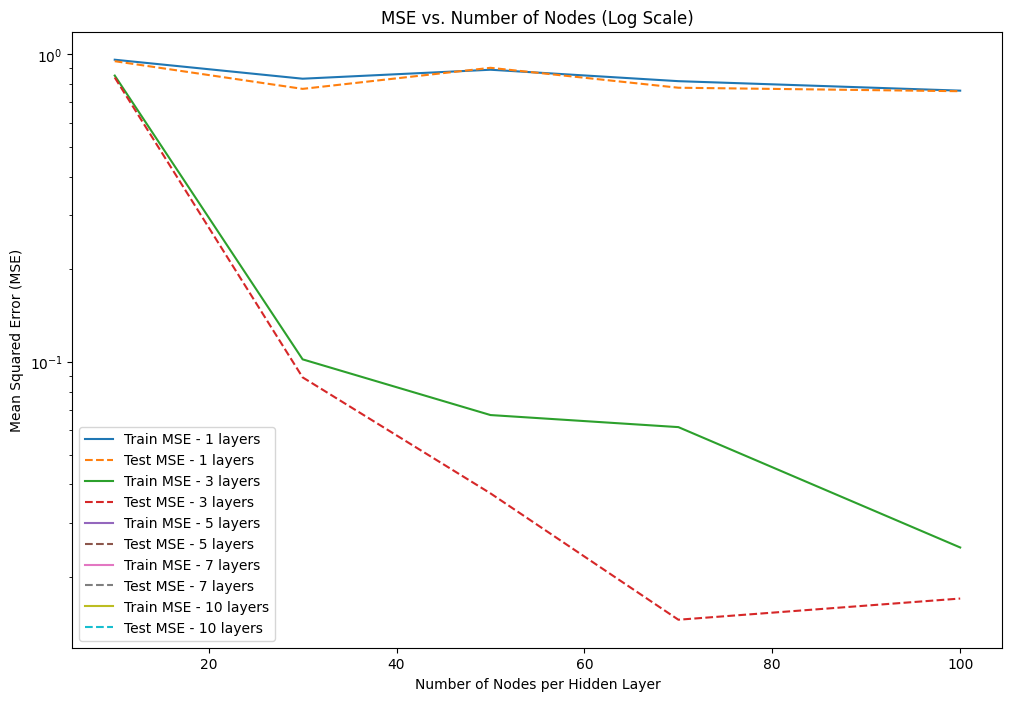

Train MSE: 0.0296, Test MSE: 0.0184
R2 score (Test): 0.9940
MAE (Train): 0.1016, MAE (Test): 0.0979


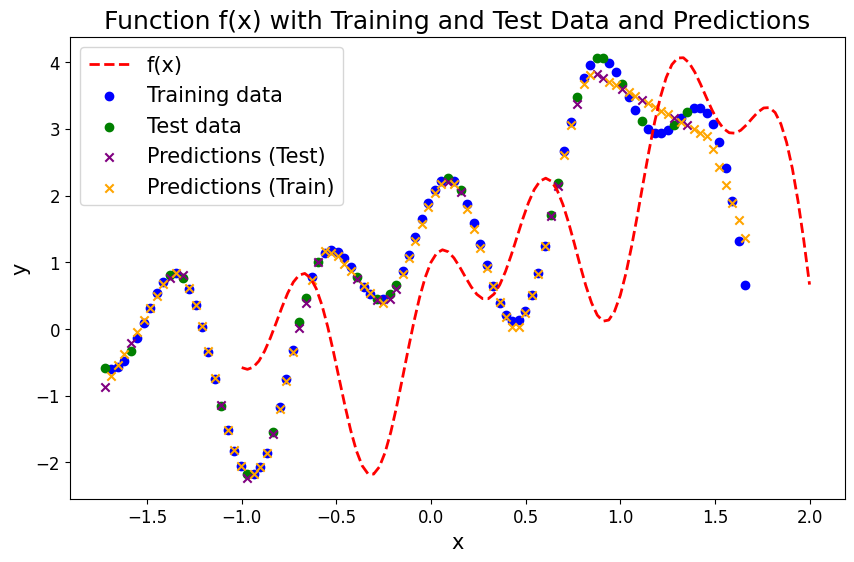

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics.functional import r2_score, mean_squared_error, mean_absolute_error

# Define the function f(x)
def f(x):
    return x + 1.5 * x**2 + 0.5 * x**3 - 0.7 * x**4 + np.sin(5 * x) + np.cos(10 * x)

# Generate and split data
x = np.linspace(-1, 2, 100).reshape(-1, 1)
y = f(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.75, random_state=42)

# Normalize the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

class Data(Dataset):
    def __init__(self, x: np.ndarray, y: np.ndarray, device: str = 'cpu'):
        self.x = torch.from_numpy(x).float().to(device)
        self.y = torch.from_numpy(y).float().to(device)
        self.len = self.x.shape[0]
    
    def __getitem__(self, index: int) -> tuple:
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.len

class MLP(nn.Module):
    def __init__(self, n_units: list, activation=nn.ReLU()):
        super().__init__()
        dims_in = n_units[:-1]
        dims_out = n_units[1:]
        layers = []
        for i, (dim_in, dim_out) in enumerate(zip(dims_in, dims_out)):
            layers.append(nn.Linear(dim_in, dim_out))
            if i < len(n_units) - 2:
                layers.append(activation)
        self._layers = nn.Sequential(*layers)

    def forward(self, x):
        return self._layers(x)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

def train(model: nn.Module, train_loader: DataLoader, optimizer: torch.optim.Optimizer, criterion: nn.modules.loss._Loss):
    model.train()
    epoch_loss = 0
    n_batches = len(train_loader)
    for data, target in train_loader:
        data = data.to(DEVICE)
        target = target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.data.item()
    return epoch_loss / n_batches

def evaluate(model: nn.Module, data_loader: DataLoader, criterion: nn.modules.loss._Loss):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(DEVICE)
            target = target.to(DEVICE)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.data.item()
    return total_loss / len(data_loader) #returns avg loss per batch

# Train the model
results = []
criterion = nn.MSELoss()
hidden_layers_range = [1, 3, 5, 7, 10]  # Select specific ranges for hidden layers
nodes_range = [10, 30, 50, 70, 100]     # Select specific ranges for nodes per layer

# Loop to train a maximum of 10 different models
for num_layers in hidden_layers_range:
    for num_nodes in nodes_range:
        if len(results) >= 10:
            break
        n_units = [1] + [num_nodes] * num_layers + [1]
        model = MLP(n_units).to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=0.0005)
        
        # Evaluate the final model
        train_data = Data(x_train, y_train, device=DEVICE)
        test_data = Data(x_test, y_test, device=DEVICE)
        
        train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
        test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

        # Train the final model
        n_epochs = 500  # Adjust epochs as necessary
        for epoch in range(n_epochs):
            train(model, train_loader, optimizer, criterion)

        train_mse = evaluate(model, train_loader, criterion)
        test_mse = evaluate(model, test_loader, criterion)
        results.append((num_layers, num_nodes, train_mse, test_mse))

# Plotting MSE results for test and train data
# Log scale on MSE values vs number of nodes
df = pd.DataFrame(results, columns=["hidden_layers", "nodes", "train_mse", "test_mse"])
plt.figure(figsize=(12, 8))

for hidden_layers in hidden_layers_range:
    subset = df[df["hidden_layers"] == hidden_layers]
    plt.plot(subset["nodes"], subset["train_mse"], label=f"Train MSE - {hidden_layers} layers")
    plt.plot(subset["nodes"], subset["test_mse"], label=f"Test MSE - {hidden_layers} layers", linestyle='--')

plt.yscale('log')
plt.xlabel("Number of Nodes per Hidden Layer")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE vs. Number of Nodes (Log Scale)")
plt.legend()
plt.show()

# Optimal model with low MSE
best_model_params = df.sort_values(by="test_mse").iloc[0]
hidden_layers = int(best_model_params["hidden_layers"])
nodes = int(best_model_params["nodes"])

# Create the final model
n_units = [1] + [nodes] * hidden_layers + [1]
final_model = MLP(n_units).to(DEVICE)
optimizer = optim.Adam(final_model.parameters(), lr=0.0005)
criterion = nn.MSELoss()

# Train the final model
n_epochs = 700  # Adjust epochs as necessary
for epoch in range(n_epochs):
    train(final_model, train_loader, optimizer, criterion)

# Evaluate the final model
train_mse = evaluate(final_model, train_loader, criterion)
test_mse = evaluate(final_model, test_loader, criterion)

# Compute MAE, R^2 values for the model
final_model.eval()
with torch.no_grad():
    y_pred_test = final_model(torch.from_numpy(x_test).float().to(DEVICE))
    y_pred_train = final_model(torch.from_numpy(x_train).float().to(DEVICE))

r2_test = r2_score(y_pred_test.cpu(), torch.from_numpy(y_test).float().cpu())
mae_test = mean_absolute_error(y_pred_test.cpu(), torch.from_numpy(y_test).float().cpu())
mae_train = mean_absolute_error(y_pred_train.cpu(), torch.from_numpy(y_train).float().cpu())

# Print values
print(f'Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
print(f'R2 score (Test): {r2_test:.4f}')
print(f'MAE (Train): {mae_train:.4f}, MAE (Test): {mae_test:.4f}')

# Plot the functions and predictions
plt.figure(figsize=(10, 6))

# Plot the function f(x)
plt.plot(x, y, label='f(x)', color='red', linestyle='--', linewidth=2)

# Plot the training data
plt.scatter(x_train, y_train, label='Training data', color='blue')

# Plot the test data
plt.scatter(x_test, y_test, label='Test data', color='green')

# Plot the predictions
plt.scatter(x_test, y_pred_test.cpu(), label='Predictions (Test)', color='purple', marker='x')
plt.scatter(x_train, y_pred_train.cpu(), label='Predictions (Train)', color='orange', marker='x')

plt.legend(fontsize=15)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Function f(x) with Training and Test Data and Predictions', fontsize=18)
plt.show()